### 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path+'/open/train.csv')
test = pd.read_csv(path+'/open/test.csv')

In [3]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [4]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


### 데이터 살펴보기

In [5]:
def plot_histogram(data, columns_to_plot, cols=2, figsize=(10, 3)):
    # 해당 열이 데이터 내 존재하는 지 확인합니다.
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")
    
    # 서브플롯을 생성하기 위해 행과 열의 수를 확인합니다.
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars / cols)
    
    # 서브플롯을 생성합니다.
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    
    for i, col in enumerate(valid_columns):
        sns.histplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)
    
    # 빈 서브플롯을 삭제합니다.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

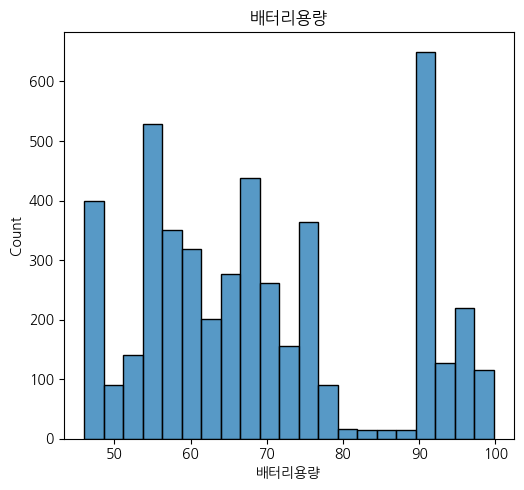

In [6]:
# 그래프를 생성할 열을 담은 리스트 입니다.
columns_to_plot = ['배터리용량']

# 선언한 함수를 사용하여 그래프를 생성합니다.
plot_histogram(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

In [7]:
train['배터리용량'].describe()

count    4786.000000
mean       69.397187
std        15.283635
min        46.000000
25%        56.359000
50%        68.125000
75%        78.227000
max        99.800000
Name: 배터리용량, dtype: float64

### Train 레이블 인코딩

In [8]:
encoded_train = train.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_train.columns if encoded_train[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_train[col])
    encoded_train[col] = le.transform(encoded_train[col])
    
# 결과 확인
print(encoded_train.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)
0   0    4  16     1  86.077     0     13642        0     0      2   159.66
1   1    3  10     1  56.000     1     10199        6     0      0    28.01
2   2    0  17     0  91.200     0      2361        7     0      0    66.27
3   3    0  12     1     NaN     0     21683        3     0      0    99.16
4   4    1  19     2  61.018     0    178205        1     0      0    62.02


### Test 레이블인코딩

In [9]:
encoded_test = test.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_test.columns if encoded_test[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_test[col])
    encoded_test[col] = le.transform(encoded_test[col])
    
# 결과 확인
print(encoded_test.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)
0   0    4  15     1  76.093     0     14057        2     0      0
1   1    1  20     0  90.000     0      7547        8     0      0
2   2    1  19     0     NaN     2      7197        7     1      0
3   3    2   2     1  68.479     0     10357        7     0      1
4   4    3   0     0     NaN     1      7597       10     0      0


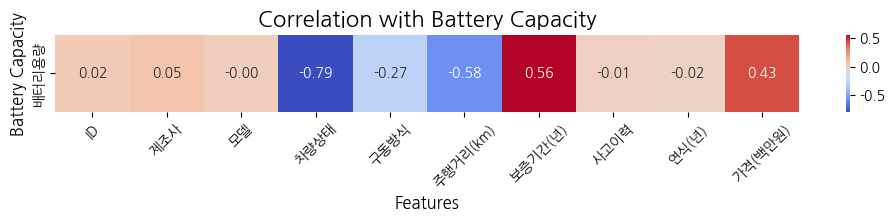

In [10]:
# '배터리용량'과 다른 변수 간의 상관계수 계산
battery_corr = encoded_train.corr()['배터리용량'].drop('배터리용량')  # '배터리용량'과의 상관계수 추출

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 1))
sns.heatmap(battery_corr.to_frame().T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation with Battery Capacity", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Battery Capacity", fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 결측값 채우기

- 배터리용량과 차량상태의 상관계수가 -0.79이므로, 차량상태를 기준으로 그룹별 중앙값으로 채울거임

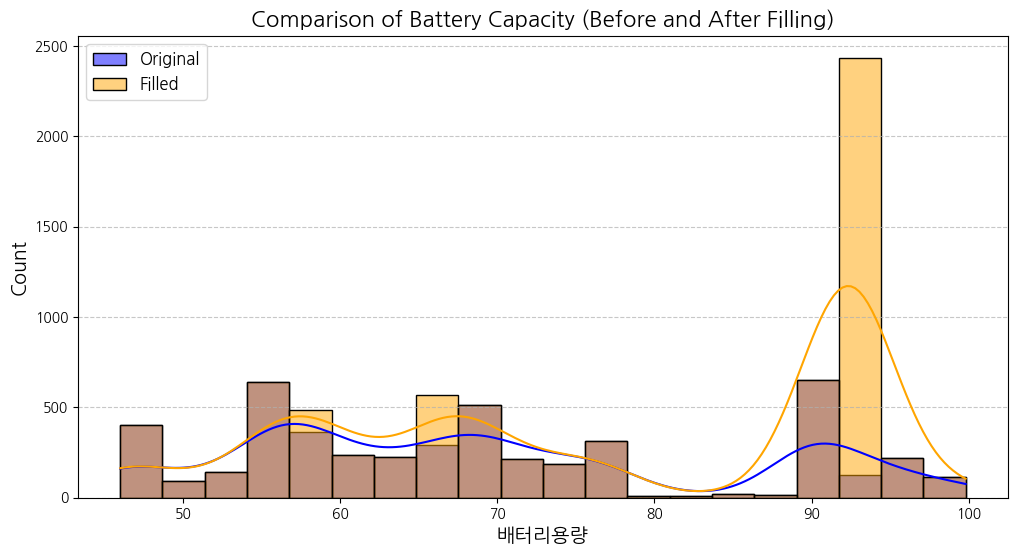

In [11]:
# encoded_filled_train = encoded_train.copy()
# # 차량상태 그룹별로 배터리용량 결측치를 중앙값으로 채우기
# encoded_filled_train['배터리용량'] = encoded_filled_train.groupby('차량상태')['배터리용량'].transform(
#     lambda x: x.fillna(x.median())
# )

# 원본 데이터 복사 (결측치가 채워지기 전 데이터)
original_data = encoded_train.copy()

# 결측치 채우기
encoded_train['배터리용량'] = encoded_train.groupby('차량상태')['배터리용량'].transform(
    lambda x: x.fillna(x.mean())
)
encoded_test['배터리용량'] = encoded_test.groupby('차량상태')['배터리용량'].transform(
    lambda x: x.fillna(x.mean())
)

# 그래프 비교
plt.figure(figsize=(12, 6))

# 원본 데이터의 히스토그램
sns.histplot(original_data['배터리용량'], bins=20, color='blue', kde=True, alpha=0.5, label='Original')

# 결측치 채운 데이터의 히스토그램
sns.histplot(encoded_train['배터리용량'], bins=20, color='orange', kde=True, alpha=0.5, label='Filled')

# 그래프 설정
plt.title('Comparison of Battery Capacity (Before and After Filling)', fontsize=16)
plt.xlabel('배터리용량', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
original_data.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,7497.000000,7497.000000,7497.000000,7497.000000,4786.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,69.397187,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949
std,2164.341817,1.885991,6.286307,0.833279,15.283635,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000
25%,1874.000000,1.000000,5.000000,0.000000,56.359000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000
50%,3748.000000,3.000000,11.000000,1.000000,68.125000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000
75%,5622.000000,4.000000,16.000000,2.000000,78.227000,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000


In [13]:
encoded_train.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,76.265973,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949
std,2164.341817,1.885991,6.286307,0.833279,16.416840,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000
25%,1874.000000,1.000000,5.000000,0.000000,61.018000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000
50%,3748.000000,3.000000,11.000000,1.000000,76.093000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000
75%,5622.000000,4.000000,16.000000,2.000000,92.586567,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000


In [14]:
encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        846 non-null    int64  
 1   제조사       846 non-null    int64  
 2   모델        846 non-null    int64  
 3   차량상태      846 non-null    int64  
 4   배터리용량     846 non-null    float64
 5   구동방식      846 non-null    int64  
 6   주행거리(km)  846 non-null    int64  
 7   보증기간(년)   846 non-null    int64  
 8   사고이력      846 non-null    int64  
 9   연식(년)     846 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 66.2 KB


### 데이터 전처리

In [15]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = encoded_train.drop(['ID', '가격(백만원)'], axis = 1)
y_train = encoded_train['가격(백만원)']

x_test = encoded_test.drop('ID', axis = 1)

### 학습 및 예측하기

In [16]:
# 모델을 선언하고, 학습을 진행합니다.
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [17]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [18]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,79.26
2,TEST_002,64.70
3,TEST_003,34.21
4,TEST_004,47.80


In [19]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240116-pred08.csv',index=False)